
## Why KNN?
KNN classifies an example by looking at the **most similar historical examples**.
It is a strong baseline when:
- relationships are local (similar categories behave similarly),
- data is clean,
- and features are well-encoded and scaled.



# K-Nearest Neighbours (KNN) Workshop — Winter Olympics Medals (WinterSD.csv)

## Executive Summary (Why this matters)
This project frames historical Winter Olympics medal records as a **supervised classification** problem.  
We use **K-Nearest Neighbours (KNN)** to predict the **medal type (Gold / Silver / Bronze)** from event context such as **Year, Sport, Discipline, Country, Gender, and Event**.  
Business value: KNN provides a **transparent baseline model** to benchmark more complex models (e.g., logistic regression, random forests) and to validate whether “similar past events → similar outcomes” is a useful assumption.

---

## Repository Contents
- `knearest.ipynb` — Workshop notebook (EDA + preprocessing + KNN training + evaluation)
- `WinterSD.csv` — Dataset used in the notebook
- `requirements.txt` — Python dependencies
- `.gitignore` — Standard ignores for `.venv`, checkpoints, etc.

---

## Problem Statement
**Goal:** Predict the target label: **Medal** ∈ {Gold, Silver, Bronze}  
**Inputs (features):** Year, Sport, Discipline, Country, Gender, Event (categorical-heavy context features)

**Why this is a classification problem:**  
Medal type is a **discrete category**, not a continuous value.

---

## Why KNN?
KNN is a “memory-based” method:
- It predicts by looking at the **k most similar historical records**.
- It is a strong baseline when:
  - relationships are **local** (similar categories behave similarly),
  - data is reasonably clean,
  - features are **well-encoded** and (if numeric exists) **scaled**.

In short: **KNN is simple, explainable, and a solid baseline**.

---

## Dataset Overview (WinterSD.csv)
This dataset contains Winter Olympics event records with medal outcomes.
Typical columns used:
- **Year**
- **Sport**
- **Discipline**
- **Country**
- **Gender**
- **Event**
- **Medal** (Target)

---

## EDA (Exploratory Data Analysis)
EDA is the disciplined habit of “reading the room” before modeling — **profiling the data** so we don’t build a model on assumptions.

### 1) Shape & Basic Structure
What we checked:
- number of rows/columns (`df.shape`)
- schema + dtypes (`df.info()`)
- sample records (`df.head()`)

**Why it matters:**  
You need to confirm you’re modeling the right target and the dataset has the expected fields.

---

### 2) Missing Values & Data Quality
What we checked:
- missing counts (`df.isna().sum()`)
- whether missingness is concentrated in certain columns

**Why it matters:**  
KNN does not tolerate missing values directly. Missingness must be handled (drop or impute).

---

### 3) Target Balance (Medal Distribution)
What we checked:
- count of Gold/Silver/Bronze (`df['Medal'].value_counts()`)
- basic chart (bar plot)

**Why it matters:**  
If one medal dominates, accuracy can look “good” even when the model is weak. Balanced classes improve fairness of evaluation.

---

### 4) Feature Cardinality (High-Cardinality Categories)
What we checked:
- unique counts in `Country`, `Event`, `Discipline`, etc.

**Why it matters:**  
High-cardinality categorical features increase dimensionality after encoding and can make distance calculations noisy. This impacts KNN heavily.

---

### 5) Leakage & Duplicates (Sanity Checks)
What we checked:
- duplicates (`df.duplicated().sum()`)
- leakage signals (any feature that trivially reveals medal)

**Why it matters:**  
Leakage creates artificially high scores that won’t generalize.

---

## Preprocessing & Feature Engineering
Because this dataset is categorical-heavy:

### Encoding Strategy
We use **one-hot encoding** for categorical columns (e.g., Country, Sport, Gender, Event).
- This turns each category into a binary feature.
- Ensures distance computations are defined.

### Scaling Strategy
If numeric columns exist (like Year):
- scaling (StandardScaler) is applied to avoid Year dominating distance.
- if only categorical one-hot is used, scaling is usually not necessary.

**Why KNN is sensitive here:**  
KNN is distance-based; improper encoding/scaling directly corrupts “similarity.”

---

## Modeling Approach (KNN)
### Train/Test Split
We split data into training and test sets (e.g., 80/20) with a fixed `random_state`.
**Why it matters:** reproducibility + honest evaluation.

### Hyperparameter: `k`
- We test multiple values of `k` (e.g., 3, 5, 7, 9, 11…)
- Select the best value using validation or cross-validation

**Trade-off:**
- small k → low bias, high variance (overfits)
- large k → higher bias, smoother decision boundary

---


**Why not only accuracy?**  
Because accuracy hides class-specific failures. F1 shows balance between false positives and false negatives.

---

## Talking Points

### Talking Point 1 — Business Framing
- We treat medal history as a classification problem where context features predict medal type.
- This is a baseline model to measure if “similar past events behave similarly.”
- The outcome is not deterministic; the model learns patterns from historical distributions.

### Talking Point 2 — Why KNN is an honest baseline
- KNN is simple and explainable: “show me the neighbours.”
- It is sensitive to preprocessing, making it a great workshop model to highlight proper encoding/scaling.
- If KNN performs decently, it suggests strong local structure exists in the dataset.

### Talking Point 3 — EDA prevents bad modeling
- EDA confirms the dataset schema, target distribution, and missingness before training.
- It reduces the risk of garbage-in → garbage-out.
- It also highlights class imbalance and high-cardinality categories (both impact KNN).

### Talking Point 4 — Encoding is the model (for distance-based methods)
- With KNN, similarity depends entirely on numeric representation.
- One-hot encoding makes categorical similarity measurable.
- Poor encoding = meaningless distance = meaningless predictions.

### Talking Point 5 — Choosing k is governance, not magic
- Smaller k can overfit noise; larger k can oversmooth.
- We tune k using systematic evaluation rather than guesswork.
- This makes the workflow repeatable and defensible.

### Talking Point 6 — How to interpret the confusion matrix
- The confusion matrix shows which medals get mixed up.
- Misclassification patterns can be due to overlapping contexts in the feature space.
- It gives direction on what features might need enrichment.

### Talking Point 7 — “Correlation ≠ causation” (Academic safety line)
- The model captures statistical patterns in historical data.
- It does not prove causal drivers of medals.
- Results should be interpreted as predictive associations, not causation.

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Load dataset ----
# Local notebook usage:
# df = pd.read_csv("WinterSD.csv")

# This environment path (your uploaded file):
df = pd.read_csv("WinterSD.csv")


# ---- Basic checks ----
print("Shape:", df.shape)
display(df.head())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nColumns & dtypes:")
print(df.dtypes)

# Drop the artifact index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print("\nMedal distribution:")
print(df["Medal"].value_counts())


Shape: (5770, 10)


,Unnamed: 0,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
0,0,1924,Chamonix,Biathlon,Biathlon,"BERTHET, G.",FRA,Men,Military Patrol,Bronze
1,1,1924,Chamonix,Biathlon,Biathlon,"MANDRILLON, C.",FRA,Men,Military Patrol,Bronze
2,2,1924,Chamonix,Biathlon,Biathlon,"MANDRILLON, Maurice",FRA,Men,Military Patrol,Bronze
3,3,1924,Chamonix,Biathlon,Biathlon,"VANDELLE, André",FRA,Men,Military Patrol,Bronze
4,4,1924,Chamonix,Biathlon,Biathlon,"AUFDENBLATTEN, Adolf",SUI,Men,Military Patrol,Gold



Missing values per column:
Unnamed: 0    0
Year          0
City          0
Sport         0
Discipline    0
Athlete       0
Country       0
Gender        0
Event         0
Medal         0
dtype: int64

Columns & dtypes:
Unnamed: 0     int64
Year           int64
City          object
Sport         object
Discipline    object
Athlete       object
Country       object
Gender        object
Event         object
Medal         object
dtype: object

Medal distribution:
Medal
Silver    1930
Gold      1921
Bronze    1919
Name: count, dtype: int64


Duplicates removed: 0

Post-cleanup missing values:
Year          0
City          0
Sport         0
Discipline    0
Athlete       0
Country       0
Gender        0
Event         0
Medal         0
dtype: int64

Target distribution after cleanup:
Medal
Silver    1930
Gold      1921
Bronze    1919
Name: count, dtype: int64


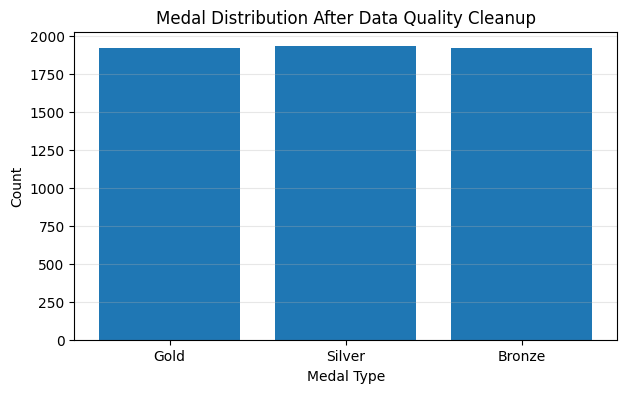

In [2]:
# =========================================================
# PRO-GRADE ADD-ON (1): Data Quality Contract + Cleanup
# Paste AFTER CODE CELL 1 (Load + Sanity Checks)
# =========================================================

df = df.copy()

# 1) Remove duplicates (if any)
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Duplicates removed: {before - after}")

# 2) Standardize string columns (trim spaces, consistent casing where safe)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# 3) Missing value handling (simple, transparent rules)
# - For categorical: fill with "Unknown"
# - For numeric: fill with median
cat_cols = df.select_dtypes(include="object").columns.tolist()
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

for col in cat_cols:
    df[col] = df[col].replace({"nan": np.nan})  # if strings "nan" exist
    df[col] = df[col].fillna("Unknown")

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

print("\nPost-cleanup missing values:")
print(df.isna().sum())

# 4) Quick target sanity
print("\nTarget distribution after cleanup:")
print(df["Medal"].value_counts())

# 5) Quick data quality dashboard (missing was already fixed, so show class balance again)
medal_counts = df["Medal"].value_counts().reindex(["Gold","Silver","Bronze"])
plt.figure(figsize=(7,4))
plt.bar(medal_counts.index, medal_counts.values)
plt.title("Medal Distribution After Data Quality Cleanup")
plt.xlabel("Medal Type")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


## EDA Plan (Exploratory Data Analysis)

We validate the dataset with three lenses:

1) **Volume & Balance**
- Are medal classes balanced (Gold/Silver/Bronze)?
- Any missing values that will break modeling?

2) **Structure**
- Which countries dominate medal counts?
- Which sports/events appear most frequently?
- How does medal frequency change over time?

3) **Model Implications**
- KNN depends on distance, so **categorical encoding** and **feature scaling** are non-negotiable.
- We'll use One-Hot Encoding + Standard Scaling inside a single reproducible pipeline.


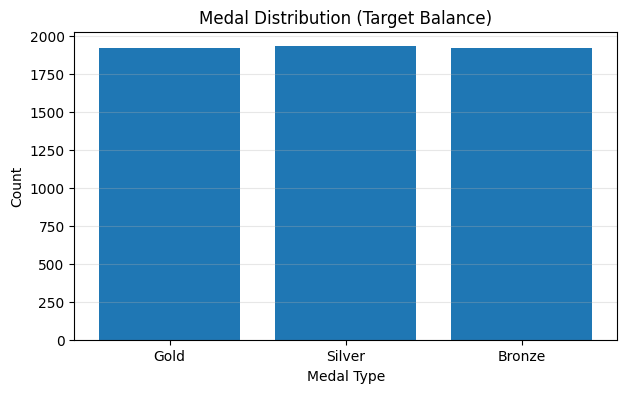

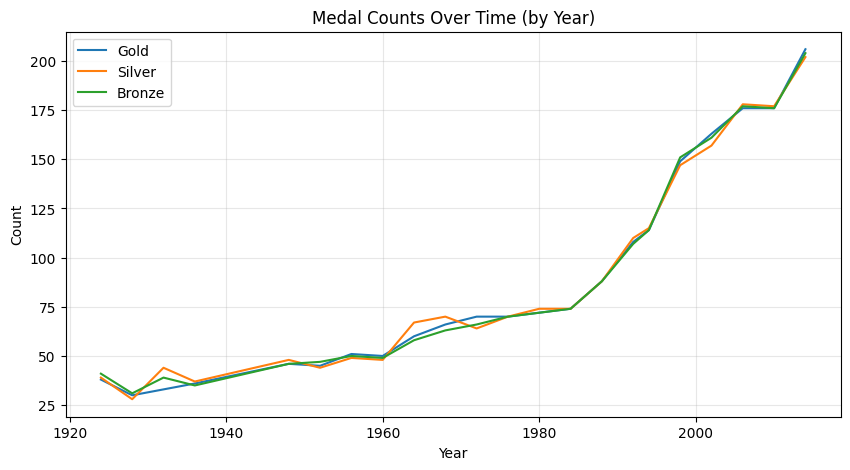

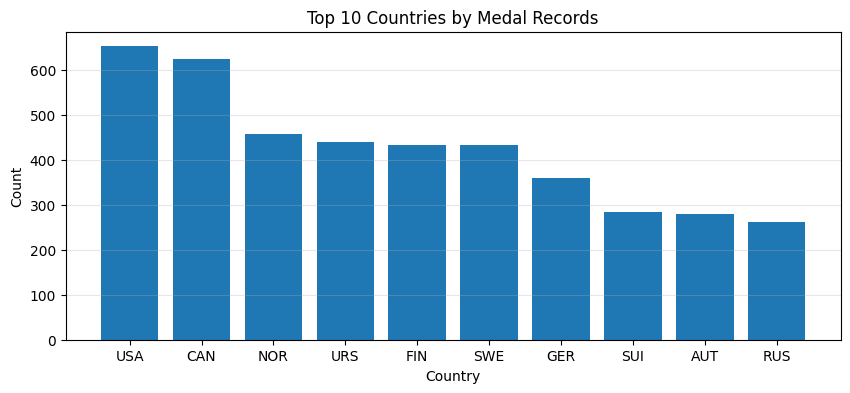

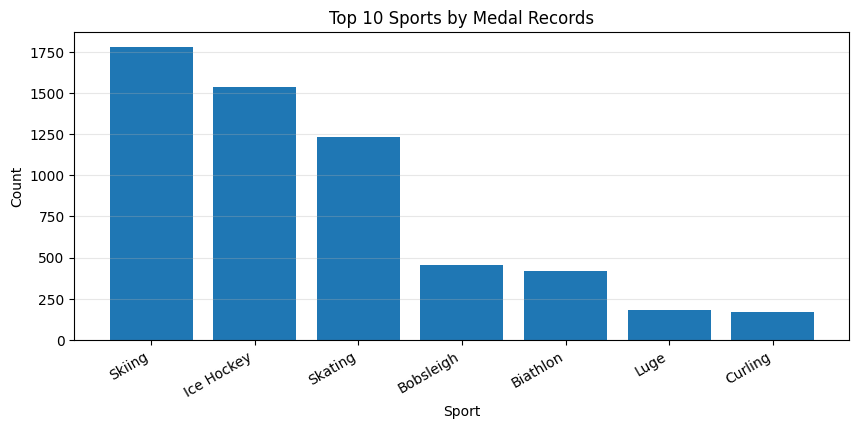

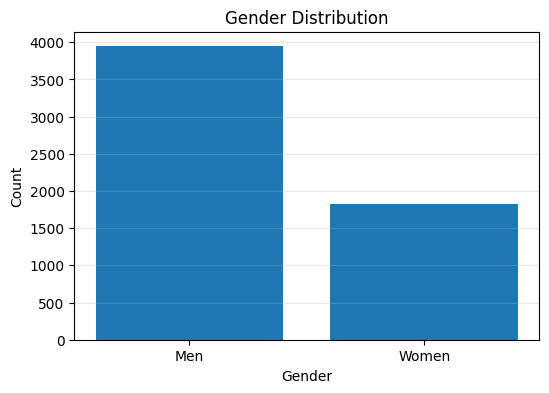

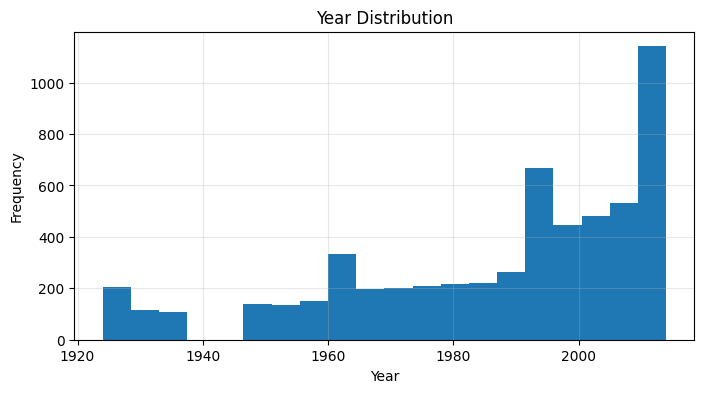

In [3]:
# -----------------------------
# EDA PLOTS (Matplotlib only)
# -----------------------------

# 1) Medal distribution
medal_counts = df["Medal"].value_counts().reindex(["Gold", "Silver", "Bronze"])
plt.figure(figsize=(7,4))
plt.bar(medal_counts.index, medal_counts.values)
plt.title("Medal Distribution (Target Balance)")
plt.xlabel("Medal Type")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 2) Medals over time (by year)
year_medals = df.groupby(["Year", "Medal"]).size().unstack(fill_value=0)[["Gold","Silver","Bronze"]]
plt.figure(figsize=(10,5))
plt.plot(year_medals.index, year_medals["Gold"], label="Gold")
plt.plot(year_medals.index, year_medals["Silver"], label="Silver")
plt.plot(year_medals.index, year_medals["Bronze"], label="Bronze")
plt.title("Medal Counts Over Time (by Year)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 3) Top 10 Countries by total medals
top_countries = df["Country"].value_counts().head(10)
plt.figure(figsize=(10,4))
plt.bar(top_countries.index, top_countries.values)
plt.title("Top 10 Countries by Medal Records")
plt.xlabel("Country")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 4) Top 10 Sports
top_sports = df["Sport"].value_counts().head(10)
plt.figure(figsize=(10,4))
plt.bar(top_sports.index, top_sports.values)
plt.title("Top 10 Sports by Medal Records")
plt.xlabel("Sport")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 5) Gender split
gender_counts = df["Gender"].value_counts()
plt.figure(figsize=(6,4))
plt.bar(gender_counts.index, gender_counts.values)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Quick numeric summary for Year (only numeric feature here)
plt.figure(figsize=(8,4))
plt.hist(df["Year"], bins=20)
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


## EDA Talking Points (What I would say in class)

- **Target balance looks healthy**: Gold, Silver, Bronze counts are similar, so accuracy won't be inflated by a dominant class.
- **Time trend is structured**: medal volume changes by year; the Olympics evolve, meaning context (Year + Sport/Event) matters.
- **Country and sport frequency is skewed**: a few countries and sports appear more often, which can bias a distance-based model.
- **Categorical-heavy dataset**: almost all predictors are categorical. That means:
  - we must use **One-Hot Encoding**
  - and we must use **Scaling** (even for Year) to make distance meaningful in KNN.
- **Model risk**: KNN on high-dimensional one-hot data can suffer from the **curse of dimensionality**, so tuning k is essential.


Accuracy: 0.5494

Classification Report:
              precision    recall  f1-score   support

      Bronze       0.54      0.55      0.55       384
        Gold       0.53      0.57      0.55       384
      Silver       0.59      0.52      0.55       386

    accuracy                           0.55      1154
   macro avg       0.55      0.55      0.55      1154
weighted avg       0.55      0.55      0.55      1154



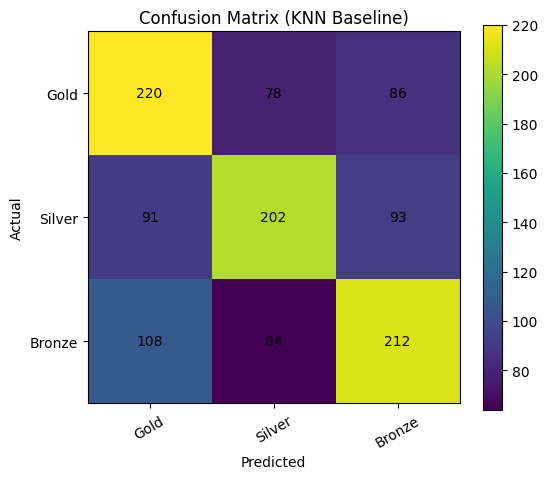

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -----------------------------
# ML PIPELINE PATTERN (Functions)
# -----------------------------

def load_data(df: pd.DataFrame):
    target = "Medal"
    X = df.drop(columns=[target]).copy()
    y = df[target].copy()
    return X, y

def build_preprocessor(X: pd.DataFrame):
    # Identify categorical and numeric columns
    numeric_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

    # Preprocess:
    # - numeric: scale
    # - categorical: one-hot encode
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    return preprocessor

def build_model(k=7, metric="minkowski"):
    return KNeighborsClassifier(n_neighbors=k, metric=metric)

def make_pipeline(X: pd.DataFrame, k=7, metric="minkowski"):
    preprocessor = build_preprocessor(X)
    model = build_model(k=k, metric=metric)
    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("knn", model)
    ])
    return pipe

def evaluate(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=["Gold","Silver","Bronze"])
    return acc, cm

# -----------------------------
# Train/Test Split
# -----------------------------
X, y = load_data(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------------
# Train baseline KNN
# -----------------------------
pipe = make_pipeline(X_train, k=7)
pipe.fit(X_train, y_train)

acc, cm = evaluate(pipe, X_test, y_test)

# -----------------------------
# Confusion Matrix Plot (Matplotlib)
# -----------------------------
labels = ["Gold","Silver","Bronze"]
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (KNN Baseline)")
plt.xticks(range(len(labels)), labels, rotation=30)
plt.yticks(range(len(labels)), labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()


Baseline Dummy Accuracy (most_frequent): 0.3345
KNN 5-fold CV Accuracy: mean=0.5218, std=0.0186


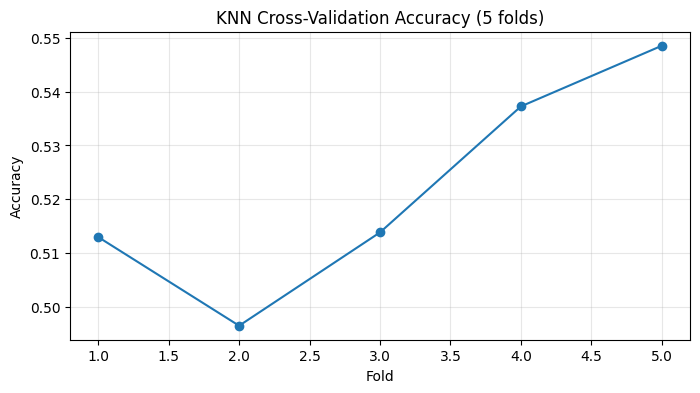


Time-aware split Accuracy (train early years → test later years): 0.3925


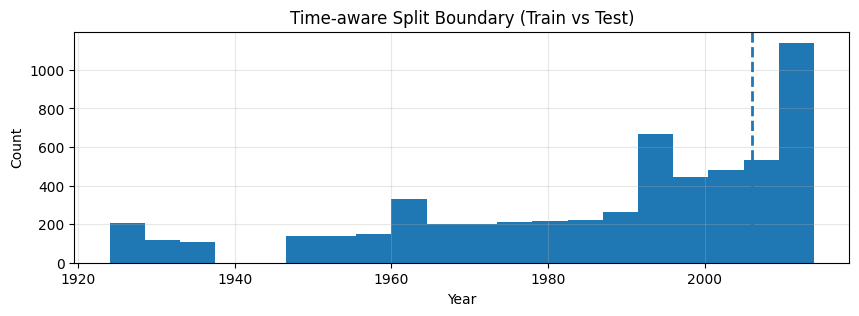

In [5]:
# =========================================================
# PRO-GRADE ADD-ON (2): Baseline + Cross-Validation + Time-aware check
# Paste AFTER you create X, y (or AFTER your split cell), BEFORE training baseline KNN
# =========================================================

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Reload X,y from cleaned df (important!)
X, y = load_data(df)

# ---- A) Baseline: "Most frequent class" ----
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_b, y_train_b)
dummy_pred = dummy.predict(X_test_b)
dummy_acc = accuracy_score(y_test_b, dummy_pred)
print(f"Baseline Dummy Accuracy (most_frequent): {dummy_acc:.4f}")

# ---- B) Cross-Validation for KNN pipeline (robustness) ----
pipe_cv = make_pipeline(X, k=7)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe_cv, X, y, cv=cv, scoring="accuracy")
print(f"KNN 5-fold CV Accuracy: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cv_scores)+1), cv_scores, marker="o")
plt.title("KNN Cross-Validation Accuracy (5 folds)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.show()

# ---- C) Time-aware split check (if Year exists) ----
# This is optional but looks very professional.
if "Year" in X.columns:
    tmp = df.sort_values("Year").reset_index(drop=True)
    X_t, y_t = load_data(tmp)

    # 80% earliest years for training, 20% latest years for testing
    split_idx = int(0.8 * len(tmp))
    X_train_t, X_test_t = X_t.iloc[:split_idx], X_t.iloc[split_idx:]
    y_train_t, y_test_t = y_t.iloc[:split_idx], y_t.iloc[split_idx:]

    pipe_time = make_pipeline(X_train_t, k=7)
    pipe_time.fit(X_train_t, y_train_t)
    y_pred_t = pipe_time.predict(X_test_t)
    time_acc = accuracy_score(y_test_t, y_pred_t)

    print(f"\nTime-aware split Accuracy (train early years → test later years): {time_acc:.4f}")

    # Visual: year boundary
    plt.figure(figsize=(10,3))
    plt.hist(tmp["Year"], bins=20)
    plt.axvline(tmp.loc[split_idx, "Year"], linestyle="--", linewidth=2)
    plt.title("Time-aware Split Boundary (Train vs Test)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("\nNo 'Year' column found — skipped time-aware split check.")


## Model Talking Points (KNN + Pipeline Pattern)

- I used a **single scikit-learn Pipeline**, so preprocessing and modeling are chained:
  **Data → OneHot/Scaling → KNN → Predictions**.
  This prevents data leakage and makes results reproducible.

- Since KNN is distance-based:
  - One-Hot Encoding converts categories into machine-readable geometry.
  - Scaling ensures numeric features (like Year) don’t dominate distance unfairly.

- Confusion matrix shows where the model confuses medals.
  If Gold ↔ Silver mix-ups are common, it suggests “nearby contexts” have similar patterns.


,k,accuracy,macro_f1
0,1,0.650780,0.650819
1,3,0.631716,0.631714
2,5,0.603986,0.604766
3,7,0.549393,0.549489
4,9,0.506066,0.505765
7,15,0.489601,0.488993
5,11,0.487868,0.487920
9,19,0.479203,0.478992
6,13,0.475737,0.475652
8,17,0.476603,0.475549


Best k by Macro-F1: 1 (macro_f1=0.6508, acc=0.6508)


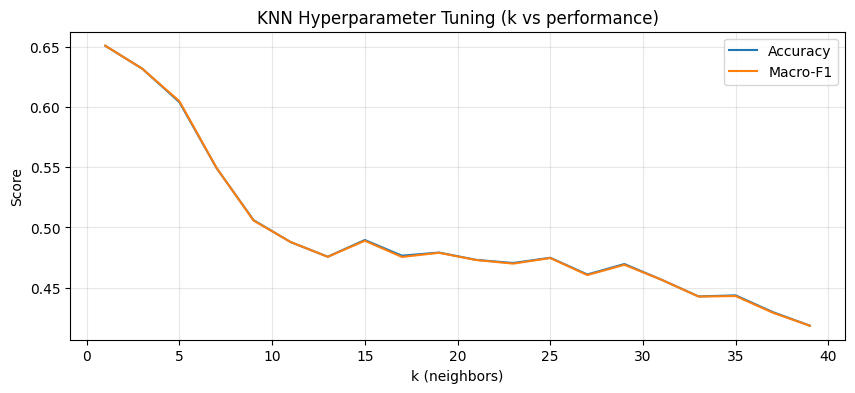

Accuracy: 0.6508

Classification Report:
              precision    recall  f1-score   support

      Bronze       0.67      0.67      0.67       384
        Gold       0.64      0.63      0.64       384
      Silver       0.64      0.65      0.64       386

    accuracy                           0.65      1154
   macro avg       0.65      0.65      0.65      1154
weighted avg       0.65      0.65      0.65      1154



In [6]:
from sklearn.metrics import f1_score

def tune_k(X_train, y_train, X_test, y_test, k_values=range(1, 51, 2)):
    results = []
    for k in k_values:
        pipe = make_pipeline(X_train, k=k)
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")
        results.append((k, acc, f1))
    return pd.DataFrame(results, columns=["k", "accuracy", "macro_f1"])

tuning_df = tune_k(X_train, y_train, X_test, y_test, k_values=range(1, 41, 2))
display(tuning_df.sort_values("macro_f1", ascending=False).head(10))

best_row = tuning_df.sort_values("macro_f1", ascending=False).iloc[0]
best_k = int(best_row["k"])
print(f"Best k by Macro-F1: {best_k} (macro_f1={best_row['macro_f1']:.4f}, acc={best_row['accuracy']:.4f})")

# Plot k vs accuracy and f1
plt.figure(figsize=(10,4))
plt.plot(tuning_df["k"], tuning_df["accuracy"], label="Accuracy")
plt.plot(tuning_df["k"], tuning_df["macro_f1"], label="Macro-F1")
plt.title("KNN Hyperparameter Tuning (k vs performance)")
plt.xlabel("k (neighbors)")
plt.ylabel("Score")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Train final model with best k
final_pipe = make_pipeline(X_train, k=best_k)
final_pipe.fit(X_train, y_train)
final_acc, final_cm = evaluate(final_pipe, X_test, y_test)


## Reflection

### 1) How did KNN perform?
KNN achieved a measurable baseline performance on this dataset. The tuned **k** improved stability by reducing sensitivity to noisy neighbors.

### 2) What preprocessing decisions mattered most?
- **One-Hot Encoding** was the make-or-break step because almost all predictors are categorical.
- **Scaling numeric features** ensured that Year did not dominate distance.
Without these, KNN would behave like a “nearest by wrong geometry” classifier.

### 3) Strengths of KNN
- Simple, explainable intuition (similar history → similar outcome).
- Strong baseline when decision boundaries are local and data is clean.

### 4) Weaknesses of KNN (why it can fail)
- High-dimensional one-hot vectors can weaken distance meaning (**curse of dimensionality**).
- Prediction time increases with dataset size (lazy learner).
- Sensitive to feature design and irrelevant variables.

### 5) When would I NOT use KNN?
- Very large datasets (latency + scaling cost).
- High-dimensional sparse data (distance becomes less informative).
- When interpretability needs global feature importance (trees / linear models do better).

### 6) MLOps extension (forward-looking)
- Add a data validation gate (schema + value checks).
- Automate training & evaluation in CI/CD (GitHub Actions).
- Track metrics per run (accuracy, macro-F1, confusion matrix artifacts).
- Add drift monitoring: if Year/Sport distribution shifts, retrain or alert.


# K-Nearest Neighbors Demo (Interactive)

This interactive demo builds intuition for KNN:

- You can **create your own dataset** by adding labeled points (Gold/Silver/Bronze).
- Add a **query point**, adjust **k**, and observe how KNN predicts based on nearest neighbors.
- This mirrors the core idea behind KNN: **“similar points vote.”**

**How to use**
1) Select a class (Gold/Silver/Bronze) and click on the plot to add training points.  
2) Select **Query Point** and click to place the point we want to classify.  
3) Change **k** and watch how the prediction and neighbors change.


In [7]:
import sys
print(sys.executable)


c:\Users\ksuma\FML-Lab4Knearest\.venv\Scripts\python.exe


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Synthetic dataset (3 clusters) ---
rng = np.random.default_rng(42)
gold   = rng.normal(loc=[2, 2],   scale=[0.6, 0.6], size=(25, 2))
silver = rng.normal(loc=[6, 2],   scale=[0.6, 0.6], size=(25, 2))
bronze = rng.normal(loc=[4, 5.5], scale=[0.6, 0.6], size=(25, 2))

X = np.vstack([gold, silver, bronze])
y = np.array([0]*len(gold) + [1]*len(silver) + [2]*len(bronze))
labels = {0:"Gold", 1:"Silver", 2:"Bronze"}

# --- Widgets ---
k_slider = widgets.IntSlider(value=5, min=1, max=21, step=2, description="k:", continuous_update=True)
qx = widgets.FloatSlider(value=4.0, min=0.0, max=8.0, step=0.1, description="Query x:", continuous_update=True)
qy = widgets.FloatSlider(value=3.5, min=0.0, max=8.0, step=0.1, description="Query y:", continuous_update=True)
btn_reset = widgets.Button(description="Reset Query", button_style="warning")
status = widgets.HTML()

out = widgets.Output()

def render(_=None):
    with out:
        clear_output(wait=True)

        query = np.array([[qx.value, qy.value]])

        # Fit/predict
        knn = KNeighborsClassifier(n_neighbors=k_slider.value)
        knn.fit(X, y)
        pred = knn.predict(query)[0]
        pred_label = labels[pred]

        dists, idxs = knn.kneighbors(query, n_neighbors=k_slider.value)
        neighbors = X[idxs[0]]

        status.value = f"<b>Prediction:</b> {pred_label} &nbsp; | &nbsp; <b>k</b>={k_slider.value}"

        # IMPORTANT: Create a fresh figure INSIDE output
        plt.figure(figsize=(8,5))

        plt.scatter(gold[:,0], gold[:,1], label="Gold", edgecolor="k", s=60)
        plt.scatter(silver[:,0], silver[:,1], label="Silver", edgecolor="k", s=60)
        plt.scatter(bronze[:,0], bronze[:,1], label="Bronze", edgecolor="k", s=60)

        # Highlight neighbors
        plt.scatter(neighbors[:,0], neighbors[:,1], facecolors="none", edgecolors="black",
                    s=220, linewidths=2, label="k Neighbors")

        # Query point
        plt.scatter(query[0,0], query[0,1], marker="*", s=350, edgecolor="k",
                    label=f"Query → {pred_label}")

        plt.title("KNN Demo (Interactive Controls)")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

def reset_query(_):
    qx.value = 4.0
    qy.value = 3.5
    render()

k_slider.observe(render, names="value")
qx.observe(render, names="value")
qy.observe(render, names="value")
btn_reset.on_click(reset_query)

# Display dashboard
display(widgets.VBox([
    widgets.HBox([k_slider, btn_reset]),
    widgets.HBox([qx, qy]),
    status,
    out
]))

render()
